Cell types in the mouse cortex and hippocampus revealed by single-cell RNA-seq

_Zeisel et al., Science 2015_

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

import multiprocessing
import warnings

In [2]:
from negbin_val_functions import *
from ab_fitting import *

In [3]:
warnings.simplefilter('ignore')
raw = pd.read_csv("/home/npapado/Documents/data/mousecort/expression_mRNA_17-Aug-2014.txt",
                   sep = "\t", header=None)
# apparently this includes only the 3005 cells used for clustering
# but the cells excluded were either low-quality or non-informative

In [4]:
metadata = raw[0:11]
counts = raw[11:]

read metadata

In [5]:
tissue = np.array(metadata.loc[0][2:], dtype=np.str_)
cell_group = np.array(metadata.loc[1][2:], dtype=np.int_)
total_mrna = np.array(metadata.loc[2][2:], dtype=np.int_)
well = np.array(metadata.loc[3][2:], dtype=np.int_)
sex = np.array(metadata.loc[4][2:], dtype=np.int_)
age = np.array(metadata.loc[5][2:], dtype=np.int_)
diameter = np.array(metadata.loc[6][2:], dtype=np.float)
cell_id = np.array(metadata.loc[7][2:], dtype=np.str_)
level1_class = np.array(metadata.loc[8][2:], dtype=np.str_)
level2_class = np.array(metadata.loc[9][2:], dtype=np.str_)

format data correctly

In [6]:
gene_names = np.array(counts[0])
gene_group = np.array(counts[1])
X = np.array(counts.loc[:, 2:], dtype = np.int_)

In [7]:
# remove genes with less than a combined 25 mRNA molecules
print(X.shape)
combmRNA = np.sum(X, axis=1)
cellmRNA = np.sum(X, axis=0)
print(combmRNA.shape)
keep = [i for i, s in enumerate(combmRNA) if s >= 25]
print(len(keep))
X = X[keep]
X = X.T
print(X.shape)

(19972, 3005)
(19972,)
15251
(3005, 15251)


isolate the subgroups and fit Negative Binomials, Gaussians and Poisson for every gene in each group separately

In [8]:
def run_subgroup(i):
    group = groups[i]
    print(i , "/", len(groups)-1, ",", group)
    keep = np.where(level2_class == group)[0]
    combmRNA = np.sum(X[keep,:], axis=0)
    genes = (combmRNA > 20)
    G = sum(genes)
    
    sum_all = np.sum(X[keep], axis=1)
    scalings = sum_all / np.mean(sum_all)

    X[keep] = (X[keep].transpose() / scalings).transpose()

    norm_pvals, mu_res, s2_res = fit_normals(G, X[keep][:, genes], scalings)
    pois_pvals, lambda_res, pois_success = fit_poissons(G, X[keep][:, genes], scalings)
    negbin_pvals, p_res, r_res, nb_success = fit_negbins_pr(G, X[keep][:, genes], scalings)

    norm_all = [norm_pvals, mu_res, s2_res]
    pois_all = [pois_pvals, lambda_res, pois_success]
    negbin_all = [negbin_pvals, p_res, r_res, nb_success]

    save_all("zeisel", group, norm_all, pois_all, negbin_all)
    np.savetxt("zeisel" + "/" + group + "_negbin_which.txt", genes)

In [9]:
groups = np.unique(level2_class)
groups = np.delete(groups, np.where(groups == "(none)"))

In [27]:
warnings.simplefilter('ignore')
pool = multiprocessing.Pool(20)
maps = pool.map(run_subgroup, range(0, len(groups)))

5 / 46 , CA2Pyr2
6 / 46 , Choroid
4 / 46 , CA1PyrInt
18 / 46 , Int3
17 / 46 , Int2
7 / 46 , ClauPyr
9 / 46 , Int1
8 / 46 , Epend
12 / 46 , Int12
15 / 46 , Int15
14 / 46 , Int14
13 / 46 , Int13
11 / 46 , Int11
10 / 46 , Int10
16 / 46 , Int16
19 / 46 , Int4
1 / 46 , Astro2
2 / 46 , CA1Pyr1
3 / 46 , CA1Pyr2
0 / 46 , Astro1
20 / 46 , Int5
21 / 46 , Int6
22 / 46 , Int7
23 / 46 , Int8
24 / 46 , Int9
25 / 46 , Mgl1
26 / 46 , Mgl2
27 / 46 , Oligo1
28 / 46 , Oligo2
29 / 46 , Oligo3
30 / 46 , Oligo4
31 / 46 , Oligo5
32 / 46 , Oligo6
33 / 46 , Peric
34 / 46 , Pvm1
35 / 46 , Pvm2
36 / 46 , S1PyrDL
37 / 46 , S1PyrL23
38 / 46 , S1PyrL4
39 / 46 , S1PyrL5
40 / 46 , S1PyrL5a
41 / 46 , S1PyrL6
42 / 46 , S1PyrL6b
43 / 46 , SubPyr
44 / 46 , Vend1
45 / 46 , Vend2
46 / 46 , Vsmc


Process ForkPoolWorker-71:
Process ForkPoolWorker-65:
Process ForkPoolWorker-75:
Process ForkPoolWorker-80:
Process ForkPoolWorker-73:
Process ForkPoolWorker-64:
Process ForkPoolWorker-69:
Process ForkPoolWorker-77:
Process ForkPoolWorker-74:
Process ForkPoolWorker-68:


read the fitted $p_g, r_g$ for each gene. With them, we can derive the real $\mu_g, \sigma_g^2$ for each gene $g$. Since we have 47 different groups, we can then learn $\alpha_g$, $\beta_g$ values for each gene.

In [10]:
G = X.shape[1]
p = list(np.zeros(len(groups)))
r = list(np.zeros(len(groups)))
success = list(np.zeros(len(groups)))
which = np.zeros((len(groups), G))

mu = list(np.zeros(len(groups)))
sigma = list(np.zeros(len(groups)))

for i in range(len(groups)):
#     print(i , "/", len(groups)-1, ",", groups[i])
    group = groups[i]
    p[i], r[i], success[i], which[i] = read_negbin_params("zeisel", group)
    mu[i] = (p[i] * r[i] / (1 - p[i]))
    sigma[i] = (p[i] * r[i] / (1 - p[i])**2)

In [11]:
def fit_gene(g):
    theta = [0.3, 3]
    cells = np.where(which[:, g])[0]
    m = np.zeros(len(cells))
    s = np.zeros(len(cells))
    for i, c in enumerate(cells):
        genes = np.argwhere(which[c]).T[0]
        g_loc = np.argwhere(genes == g)[0, 0]
        m[i] = mu[c][g_loc]
        s[i] = sigma[c][g_loc]
    x = [m, s]
    bnds = ((0, None), (0, None))
    opt = sp.optimize.minimize(func, theta, args=(
        x), method="L-BFGS-B", bounds=bnds)
    return opt.x, opt.success

In [12]:
pool = multiprocessing.Pool(20)
result = np.array(pool.map(fit_gene, range(G)))
gene_fit = np.array(result[:, 1], dtype=bool)
ab = np.array([pair for pair in result[:, 0]])

In [20]:
alpha = ab[:, 0]
beta = ab[:, 1]
alpha[alpha < 0] = 0
beta[beta < 0] = 0

valid_a = ((alpha != 0.3) & (alpha > 1e-5))
valid_b = ((beta != 3) & (beta > 1e-5))

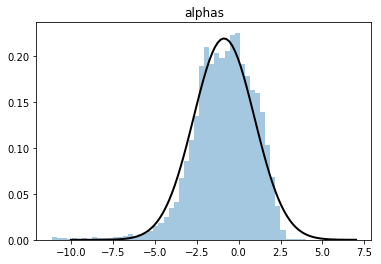

In [24]:
fig, ax = plt.subplots()
x = np.linspace(-10, 7, 100)
a_mean, a_var = hist_and_fit(np.log(alpha[valid_a]), x, ax, "alphas")

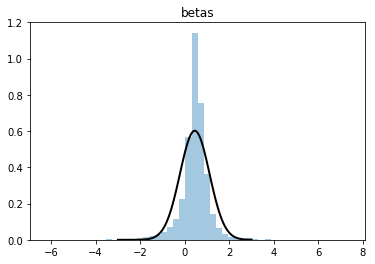

In [25]:
fig, ax = plt.subplots()
x = np.linspace(-3, 3, 100)
b_mean, b_var = hist_and_fit(np.log(beta[valid_b]), x, ax, "betas")

In [26]:
print("alpha fits:", np.exp(a_mean), np.exp(a_var))
print("beta fits:", np.exp(b_mean), np.exp(b_var))

alpha fits: 0.4187345948570119 6.144799833530924
beta fits: 1.5642979377518604 1.9400873142273332


In [27]:
from scipy.stats import norm
%matplotlib inline

for i in range(len(groups)):
    fig, ax = plt.subplots()
    group = groups[i]
    keep = np.where(level2_class == group)[0]
    sum1 = np.sum(X[keep, :], axis=1)
    scalings = sum1 / np.mean(sum1)
    s, mu, std = lognorm.fit(scalings)
    
    ax.hist(scalings, bins=25, normed=True, alpha=0.6, color='g')
    np.savetxt("zeisel/" + group + "_scalings.txt", scalings)

    # Plot the PDF.
    x = np.linspace(-1, 3, 100)
    p = lognorm.pdf(x, s, mu, std)
    ax.plot(x, p, 'k', linewidth=2)
    plt.savefig("zeisel/" + group + "_scalings.png", bbox_inches='tight')
    plt.close()
    print(group, mu, std)

Astro1 0.07145839195717862 0.8302324018796602
Astro2 0.0408172752023447 0.8716918291963388
CA1Pyr1 0.21904078414019798 0.6596966713537449
CA1Pyr2 -0.07090989430686938 0.9929237492732238
CA1PyrInt -0.09449795235198816 1.056635029543678
CA2Pyr2 -25.62483900820309 26.622754508651617
Choroid 0.32929519121516854 0.3509195425444477
ClauPyr 0.7087009116926798 0.05749714459470395
Epend 0.26194587754714366 0.4438535985786576
Int1 0.03443900566021244 0.8347423230807867
Int10 0.40054902198754816 0.38028046087378065
Int11 0.5197969543147207 0.06045016576008223
Int12 0.20027069869692635 0.7282647350838771
Int13 0.05201663233985404 0.8474202146897811
Int14 0.17529365276169273 0.7019890950927641
Int15 -22.189226059333294 23.186748401568913
Int16 0.17784788506629184 0.6694227843854472
Int2 -2.009765431029611 2.9775709648790873
Int3 0.5130116957022972 0.34092366513512773
Int4 0.3396466000765891 0.5439609980270353
Int5 0.2792118286456809 0.5194208508436742
Int6 -0.1402707115307305 1.0591352222158936
Int

In [28]:
for group in groups:
    keep = np.where(level2_class == group)[0]
    gene_means = np.mean(X[keep, :], axis=0)
    np.savetxt("zeisel/" + group + "_genes.txt", gene_means)